In [0]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.pipeline import FeatureUnion, Pipeline

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer

from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import seaborn as sns; sns.set()

import itertools

from sklearn.base import TransformerMixin

In [0]:
#Read the data using the Unnamed (probably id) as index
url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
training = pd.read_csv(url, index_col='Unnamed: 0')

labels = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 
          'Sharing', 'Student_Type', 'Use']

numeric = ['FTE', 'Total']

categoric = [ 'Facility_or_Department', 'Function_Description', 
            'Fund_Description', 'Job_Title_Description', 'Location_Description', 
            'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 
            'Sub_Object_Description', 
            'Text_1', 'Text_2', 'Text_3', 'Text_4']

## Pre-Processing

In [0]:
#Imputing data in Total column
def impute_func_total(data):
    if(pd.isnull(data['Total'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 24146
        if(data['Object_Type'] == 'Benefits'):
            return 38163
        if(data['Object_Type'] == 'Contracted Services'):
            return 24146
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 11257
        if(data['Object_Type'] == 'NO_LABEL'):
            return 58545
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 1605
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 10646
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 46611
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 1090
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 7745
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 1659
    else:
        return data['Total']

In [0]:
#Imputing data in FTE column
def impute_func_FTE(data):
    if(pd.isnull(data['FTE'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 0.45
        if(data['Object_Type'] == 'Benefits'):
            return 0.0
        if(data['Object_Type'] == 'Contracted Services'):
            return 0.0
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 0.0
        if(data['Object_Type'] == 'NO_LABEL'):
            return 0.75
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 0.000107
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 0.0
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 0.0
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 0.000059
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 0.0
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 0.0
    else:
        return data['FTE']

In [0]:
def preProcessing(training):
    # Remove inconsistent data
    training.loc[(training['FTE'] < 0) | (training['FTE'] > 1), 'FTE'] = np.nan
    training.loc[training['Total'] < 0, 'Total'] = np.nan
    
    training['Total'] = training.apply(impute_func_total, axis = 1)
    
    training['FTE'] = training.apply(impute_func_FTE, axis = 1)
    
    for category in categoric:
        training[category] = training[category].str.lower()
    
    training[categoric] = training[categoric].fillna("")
    
    return training

In [0]:
df_training = preProcessing(training)
df_training = df_training.reset_index(drop = True)

In [0]:
df_training[numeric].shape

(400277, 2)

In [0]:
df_training[categoric].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400277 entries, 0 to 400276
Data columns (total 14 columns):
Facility_or_Department    400277 non-null object
Function_Description      400277 non-null object
Fund_Description          400277 non-null object
Job_Title_Description     400277 non-null object
Location_Description      400277 non-null object
Object_Description        400277 non-null object
Position_Extra            400277 non-null object
Program_Description       400277 non-null object
SubFund_Description       400277 non-null object
Sub_Object_Description    400277 non-null object
Text_1                    400277 non-null object
Text_2                    400277 non-null object
Text_3                    400277 non-null object
Text_4                    400277 non-null object
dtypes: object(14)
memory usage: 42.8+ MB


In [0]:
def combine_text_columns(dataset):
    return dataset[categoric].apply(lambda x: " ".join(x), axis = 1)

get_text_data = FunctionTransformer(combine_text_columns, validate = False)

In [0]:
def combine_numeric_columns(dataset):
    return dataset[numeric]

get_numeric_data = FunctionTransformer(combine_numeric_columns, validate = False)

## Data Distribution and correlation

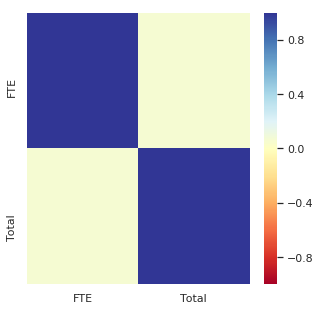

In [0]:
plt.figure(figsize=(5,5))
sns.heatmap(df_training[numeric].corr(), cmap="RdYlBu", vmin=-1, vmax=1)

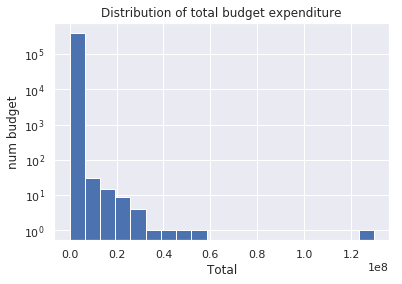

In [0]:
# Create the histogram
plt.hist(df_training['Total'], bins = 20, log = True)

# Add title and labels
plt.title('Distribution of total budget expenditure')
plt.xlabel('Total')
plt.ylabel('num budget')

# Display the histogram
plt.show()

In [0]:
text_data = df_training[categoric].apply(lambda x: " ".join(x), axis = 1)

In [0]:
vec_1 = CountVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2), stop_words = 'english')

In [0]:
X_train_features = vec_1.fit_transform(text_data)
y_train_labels = training["Object_Type"]

In [0]:
X_train_features

AttributeError: ignored

In [0]:
svd = TruncatedSVD(n_components=20)
svd.fit(X_train_features, y_train_labels)

TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
       random_state=None, tol=0.0)

In [0]:
svd.components_.shape

(20, 33207)

In [0]:
feature_list = X_train_x.get_support()


In [0]:
#List of selected KBest words
features = []
columns = []
for i in range(0, 33552):
    if(feature_list[i]):
        value = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(i)]
        x = (i, value)
        features.append(x)
        columns.append(i)

### Pipeline

In [0]:
vec = HashingVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2), stop_words = 'english')

In [0]:
clf = GaussianNB()

In [0]:
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data), 
                    ('scaler', MinMaxScaler())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', vec),
                ]))
                
             ]
        )),
        ('reduce_dim', TruncatedSVD(n_components = 150)),
        ('clf', clf)        
    ])

### Training Naive Bayes algorithm

In [0]:
d = {'NO_LABEL':1, 'Base Salary/Compensation':2, 'Benefits':3, 'Substitute Compensation':4, 'Supplies/Materials':5, 
    'Rent/Utilities':6, 'Other Compensation/Stipend': 7, 'Contracted Services' : 8, 'Equipment & Equipment Lease':9, 
     'Other Non-Compensation':10, 'Travel & Conferences':11}

In [0]:
labels_obT = df_training['Object_Type'].unique()

In [0]:
target = df_training[['Object_Type']].applymap(lambda s: d.get(s) if s in d else s)
target = target['Object_Type'].values
train = df_training.drop(columns=labels)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train,
                                                    target,
                                                    test_size=0.3, 
                                                    random_state=42)

In [0]:
pl.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function combine_numeric_columns at 0x7ffb32165b70>,
          inv_kw_args=None, invers..._iter=5,
       random_state=None, tol=0.0)), ('clf', GaussianNB(priors=None, var_smoothing=1e-09))])

In [0]:
y_pred = pl.predict(X_test)

In [0]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.7086039772159488


In [0]:
def print_report(pipe):
    report = classification_report(y_test, y_pred,
        target_names=labels_obT)
    print(report)
    print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

print_report(pl)

                             precision    recall  f1-score   support

                   NO_LABEL       0.83      0.83      0.83     20984
   Base Salary/Compensation       0.73      0.65      0.69     29238
                   Benefits       0.73      0.77      0.75     25519
    Substitute Compensation       0.62      0.86      0.72      8292
         Supplies/Materials       0.77      0.57      0.65      9624
             Rent/Utilities       0.23      0.78      0.36       983
 Other Compensation/Stipend       0.75      0.62      0.68     18404
        Contracted Services       0.65      0.55      0.59      2267
Equipment & Equipment Lease       0.79      0.67      0.73      1334
     Other Non-Compensation       0.26      0.56      0.36      1949
       Travel & Conferences       0.52      0.65      0.58      1490

                  micro avg       0.71      0.71      0.71    120084
                  macro avg       0.63      0.68      0.63    120084
               weighted avg     

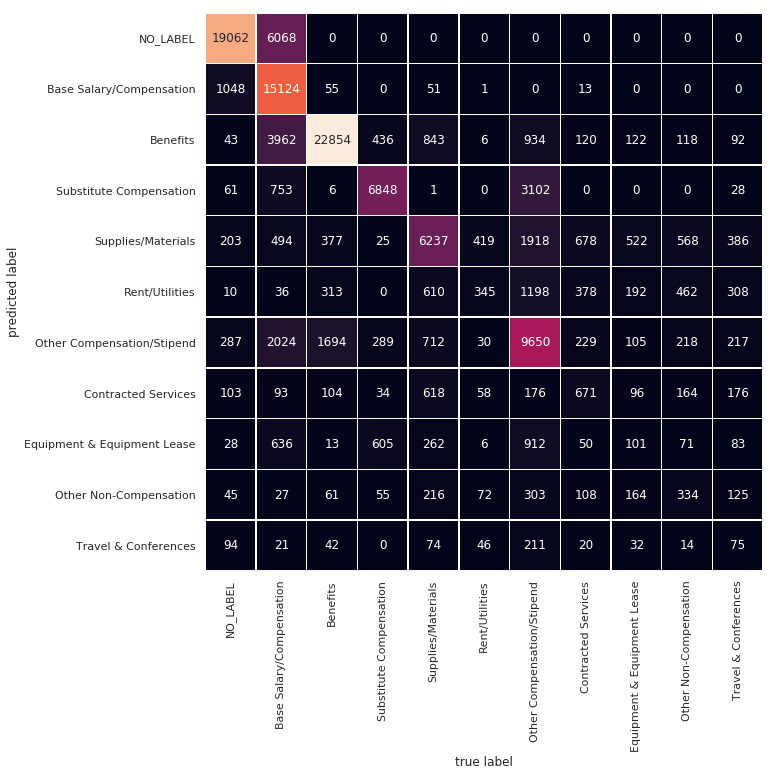

In [0]:
mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 16))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels_obT, yticklabels=labels_obT, linewidths=.5)
plt.xlabel('true label')
plt.ylabel('predicted label');